In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np

from hedging import hedging_pnl
from Black76 import Black76

### Price data

In [2]:
df = pd.read_csv('../data/data_hedging.csv', sep=';')
df = df.drop(columns=['Unnamed: 2'])
t_grid = np.array(df['Date'])
S_traj = np.array(df['Spot'])
df

,Date,Spot
0,0.000000,108.650000
1,0.002192,106.928824
2,0.004384,107.245988
3,0.006576,105.920075
4,0.008767,106.029449
...,...,...
168,0.368233,111.632960
169,0.370424,110.982896
170,0.372616,111.690640
171,0.374808,112.052551


### Model and option parameters

In [16]:
T=0.407000
K=91.780000
r=0.007000
sigma=0.261100

flag = 'c'
S0 = S_traj[0]
F0 = S0 * np.exp(r * T)

model = Black76(sigma=sigma, r=r)
def delta_Black(t, S, model=model, T=T, K=K, flag=flag):
    return model.delta(T - t, K, S * np.exp(r * (T - t)), flag)
def call_payoff(x, K=K):
    return np.maximum(x - K, 0)
V0 = model.vanilla_price(T, K, F0, flag)

In [19]:
pnl, V = hedging_pnl(t_grid, S_traj, r, delta_Black, V0, call_payoff)
pnl

-0.45521856686700346

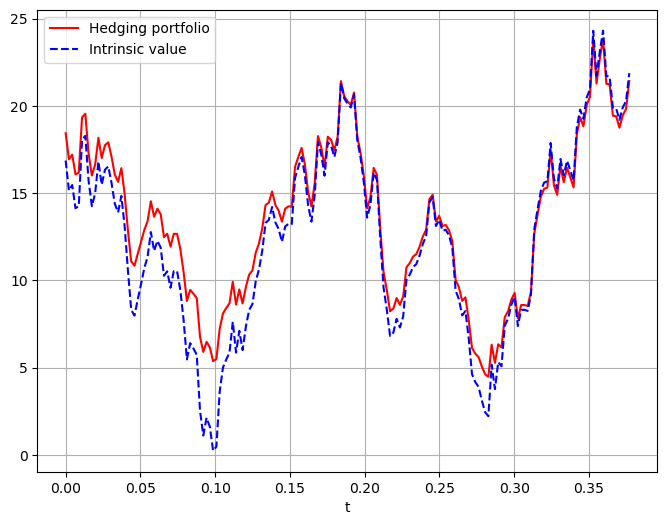

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(t_grid, V, 'r', label='Hedging portfolio')
ax.plot(t_grid, call_payoff(S_traj), 'b--', label='Intrinsic value')
ax.set_xlabel('t')
ax.legend()
ax.grid()

## Distribution of the hedging error in BS market

In [22]:
T = 1
K = 100
r = 0.01
sigma = 0.2

flag = 'c'
S0 = S_traj[0]
F0 = S0 * np.exp(r * T)

model = Black76(sigma=sigma, r=r)

#### Generating trajs

In [29]:
n_sample = 10**4
t_grid_size = 250
t_grid = np.linspace(0, T, t_grid_size)
rng = np.random.default_rng(seed=0xAB0BA)
S_traj = model.simulate_trajectory(
    size=n_sample,
    t_grid=t_grid,
    init_val=S0,
    flag='spot',
    rng=rng
)

In [26]:
V0 = model.vanilla_price(T, K, F0, flag)
def delta_Black(t, S, model=model, T=T, K=K, flag=flag):
    return model.delta(T - t, K, S * np.exp(model.r * (T - t)), flag)
def call_payoff(x, K=K):
    return np.maximum(x - K, 0)

In [27]:
pnl, V = hedging_pnl(
    t_grid=t_grid,
    S_traj=S_traj,
    r=r,
    delta=delta_Black,
    init_value=V0,
    payoff=call_payoff
)

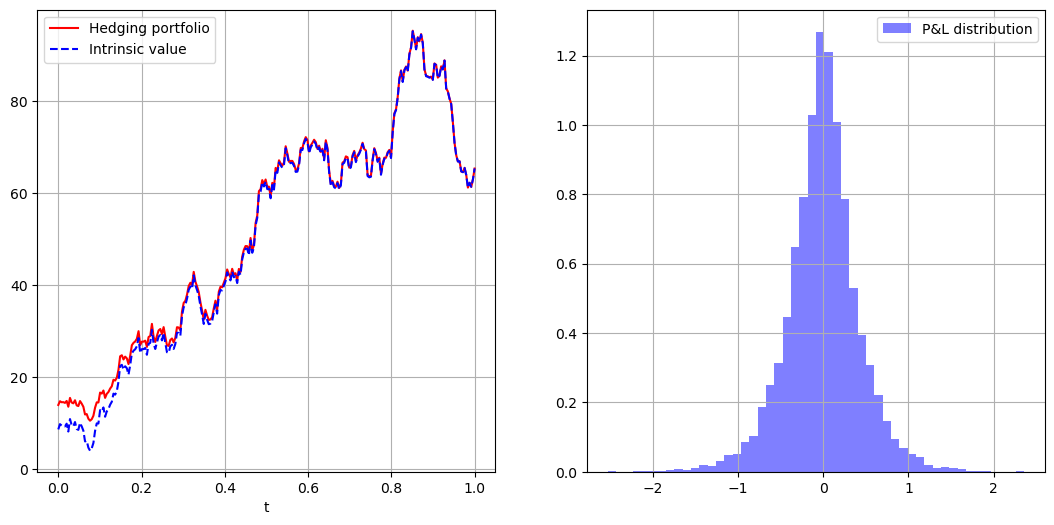

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

ax[0].plot(t_grid, V[1], 'r', label='Hedging portfolio')
ax[0].plot(t_grid, call_payoff(S_traj[1], K=K), 'b--', label='Intrinsic value')
ax[0].set_xlabel('t')
ax[0].legend()
ax[0].grid()

ax[1].hist(pnl, color='b', alpha=0.5, label='P&L distribution', density=True, bins=50)
ax[1].legend()
ax[1].grid()